In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam

from trainer.data import load_train_data, bounding_box, normalize_bounding_box, original_bounding_box
from trainer.constants import IM_SHAPE_BBOX
from trainer.models import CustomCNN, MiniCNN
from trainer.utils import bbox_loss_batch, bbox_mIOU, coord_only_mIOU, no_coord_error

np.random.seed(0)

%matplotlib inline

Using TensorFlow backend.


In [2]:
X_train, Y_train_orig = load_train_data(resize_shape=IM_SHAPE_BBOX)
Y_train_unscaled = bounding_box(Y_train_orig)
Y_train = normalize_bounding_box(Y_train_unscaled)

1.0 4.5 27.5 9.0 55.0


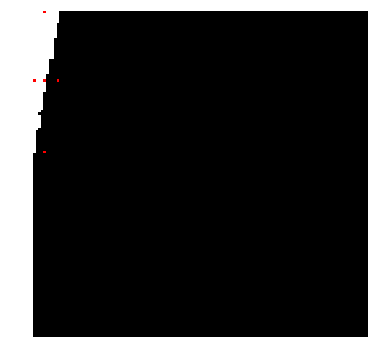

In [3]:
"""Confirm that bounding box is working"""
ix = 1001
mask = Y_train_orig[ix].astype(np.float32)
mask = np.repeat(mask, 3, 2)
p_c, b_x, b_y, b_w, b_h = Y_train_unscaled[ix]
print(p_c, b_x, b_y, b_w, b_h)

assert p_c == 1
RED = [1.0, 0, 0]
mask[int(b_y), int(b_x)] = RED
mask[int(b_y + b_h / 2), int(b_x)] = RED
mask[int(b_y - b_h / 2), int(b_x)] = RED
mask[int(b_y), int(b_x + b_w / 2)] = RED
mask[int(b_y), int(b_x - b_w / 2)] = RED

fig, ax = plt.subplots(figsize=(6, 6))
plt.axis('off')
plt.imshow(mask, aspect='auto')
plt.show()

In [4]:
model = CustomCNN()
model.summary()
earlystopper = EarlyStopping(patience=4)
tblog = TensorBoard(
        log_dir='./out/logs',
        histogram_freq=0,
        write_graph=True,
        embeddings_freq=0)
checkpointer = ModelCheckpoint('custom_cnn_model.h5', save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 192)       110592    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 192)       768       
__________

In [ ]:
LD_COORD = 1.5
LD_OBJ = 6
LD_NOOBJ = 0.1

adam_opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam_opt, loss=bbox_loss_batch(coord_scale=LD_COORD, obj_scale=LD_OBJ, noobj_scale=LD_NOOBJ),
              metrics=[bbox_mIOU, coord_only_mIOU, no_coord_error])
model.fit(x=X_train, y=Y_train, batch_size=8, epochs=20, validation_split=0.1, callbacks=[earlystopper, checkpointer, tblog])

Train on 3600 samples, validate on 400 samples
Epoch 1/20
3600/3600 [==============================] - 139s 39ms/step - loss: 446.9118 - bbox_mIOU: 0.0447 - coord_only_mIOU: 0.0447 - no_coord_error: 47.1655 - val_loss: 5.7110 - val_bbox_mIOU: 0.0063 - val_coord_only_mIOU: 0.0063 - val_no_coord_error: 0.8446
Epoch 2/20
3600/3600 [==============================] - 132s 37ms/step - loss: 24.8489 - bbox_mIOU: 0.0573 - coord_only_mIOU: 0.0573 - no_coord_error: 4.8100 - val_loss: 7.2974 - val_bbox_mIOU: 0.0814 - val_coord_only_mIOU: 0.0814 - val_no_coord_error: 0.3340
Epoch 3/20
 760/3600 [=====>........................] - ETA: 1:40 - loss: 3.3095 - bbox_mIOU: 0.0815 - coord_only_mIOU: 0.0815 - no_coord_error: 0.6562

In [10]:
def reset_train():
    import keras.backend as K
    K.clear_session()

In [6]:
Y_train_pred = model.predict(X_train)
# Y_train_pred = original_bounding_box(Y_train_pred)

In [7]:
ix=5
print(Y_train[ix])
print(Y_train_pred[ix])

[1.         0.62890625 0.49609375 0.7265625  0.9921875 ]
[ 0.6424909 -5.9981503 -4.0257206 -1.0698612  2.1899965]
